<h1>Data Exctraction - Sensor</h1>

This notebooks goal is to visualize the distribution of the different corespecs of the sensortypes. Thats done to look how why there are so many of them.

In [18]:
import pandas as pd
import plotly.express as px
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import re
import helpers.pipe_helpers as php



I extract the whole table from the excelsheet

In [19]:
mat_hülsen = pd.read_excel("../../res/06 - Spezifikation DE-EN_Vorlage_CAD.xlsx", sheet_name="01_NTC - Pt + 29_30 Widerstand")

Then I start a pipeline, where I remove unused columns, rename some columns and extract values with the help of regular expressions

In [20]:
mat_hülsen_cp = (mat_hülsen
    .pipe(php.start_pipeline)
    .pipe(php.drop_columns, column_names=["Unnamed: 0", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 11", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15"])
    .pipe(php.rename_column, column_name="Hinweis Widerstand Sensoren\n(bei Widerständen in freies Feld einfügen)\nist abhängig davon welcher Sensor-Typ verwendet wird", value="Hinweise Widerstand")
    .pipe(php.rename_column, column_name="Sensoren", value="sensor")
    .pipe(php.strip_column, column_names=["sensor"])
    .pipe(php.extract_from_regex,column_names=[("Sensorart","sensor",r'(NTC|Pt\s?\d+|.*)'),("PT_Class","sensor",r'(class\s?.*)\)'),("Widerstand","sensor", r'(R\d+=\s*\d+[,.]?\d*\s*[kK][oO][hH][mM])'),("B_Wert", "sensor",r'(B\d+/\d+\s?=\s*\d+\s*K)')])
    .pipe(php.encoding_labels,column_names=["28 Widerstand \nbei 25°C"]))


just ran step start_pipeline shape=(228, 16) took 0:00:00s
just ran step drop_columns shape=(228, 6) took 0:00:00.001010s
just ran step rename_column shape=(228, 6) took 0:00:00s
just ran step rename_column shape=(228, 6) took 0:00:00s
just ran step strip_column shape=(228, 6) took 0:00:00.001514s
just ran step extract_from_regex shape=(228, 10) took 0:00:00.004795s
just ran step encoding_labels shape=(228, 10) took 0:00:00s


<h2>Visualize the Different types of sensors</h2>

In [21]:
mat_hülsen_cp.to_csv("../../res/results/export.csv")

Here I build a tree where the different sensorcategories get visualized. For that I split after the category and the "B_Wert" or the "Widerstand"

In [22]:
import pandas as pd
from anytree import Node, RenderTree, PreOrderIter

# Focus on relevant columns and handle missing data
data_clean = mat_hülsen_cp[['Sensorart', 'PT_Class', 'B_Wert', 'Widerstand']].fillna('Unknown')

# Initialize the root of the tree and main categories
root = Node("Sensor", count=0)
pt_node = Node("PTs", parent=root, count=0)
ntc_node = Node("NTCs", parent=root, count=0)
kty_node = Node("KTYs", parent=root, count=0)
lm_node = Node("LMs", parent=root, count= 0)
others_node = Node("Others", parent=root, count=0)

# Populate the tree and count rows
for _, row in data_clean.iterrows():
    sensorart, pt_class = row['Sensorart'], row['PT_Class']
    widerstand = row['Widerstand']
    b_wert = row['B_Wert']
    
    # Determine the category and add specific nodes
    if re.match(r"Pt\s?\d+", sensorart):
        parent_node = pt_node
    elif re.match(r"NTC", sensorart):
        parent_node = root
    elif re.match(r"KTY", sensorart):
        parent_node = kty_node
    elif re.match(r"LM", sensorart):
        parent_node = lm_node
    else:
        parent_node = others_node
    
    # Increment count for the category
    parent_node.count += 1
    root.count +=1
    
    # Create or fetch the sensor node
    sensor_node_name = f"{sensorart}"
    sensor_node = next((child for child in parent_node.children if child.name.startswith(sensor_node_name)), None)
    if not sensor_node:
        sensor_node = Node(sensor_node_name, parent=parent_node, count=0)
    sensor_node.count += 1

    # Further classify PTs by 'PT_Class' and NTCs by 'Widerstand'
    if parent_node == pt_node and pt_class != 'Unknown':
        class_node_name = f"Class: {pt_class}"
        class_node = next((child for child in sensor_node.children if child.name == class_node_name), None)
        if not class_node:
            class_node = Node(class_node_name, parent=sensor_node, count=0)
        class_node.count += 1
    elif parent_node == root and widerstand != 'Unknown':
        root.count -=1
        widerstand_node_name = f"Widerstand: {widerstand}"
        widerstand_node = next((child for child in sensor_node.children if child.name == widerstand_node_name), None)
        if not widerstand_node:
            widerstand_node = Node(widerstand_node_name, parent=sensor_node, count=0)
        widerstand_node.count += 1

        if b_wert != 'Unknown':
            b_wert_node_name = f'{widerstand} B_Wert: {b_wert}'
            b_wert_node = next((child for child in widerstand_node.children if child.name == b_wert_node_name), None)
            if not b_wert_node:
                b_wert_node = Node(b_wert_node_name, parent=widerstand_node, count=0)
            b_wert_node.count += 1

# Update node names with counts
for node in PreOrderIter(root):
    node.name = f"{node.name} ({node.count})"

# Print the tree structure
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))


Sensor (228)
├── PTs (69)
│   ├── Pt1000 (55)
│   │   ├── Class: class A (20)
│   │   ├── Class: class B (19)
│   │   ├── Class: class B1/10 (4)
│   │   ├── Class: class 1/5 B (1)
│   │   ├── Class: class 1/10 B (6)
│   │   ├── Class: class 1/3 B (2)
│   │   ├── Class: class 2B (1)
│   │   └── Class: class AA (2)
│   ├── Pt500 (12)
│   │   ├── Class: class B (10)
│   │   └── Class: class A (2)
│   ├── Pt2000 (1)
│   │   └── Class: class B (1)
│   └── Pt 10 (1)
│       └── Class: class B (1)
├── NTCs (129)
│   ├── Widerstand: R25=10 kOhm (47)
│   │   ├── R25=10 kOhm B_Wert: B25/100= 3988 K (3)
│   │   ├── R25=10 kOhm B_Wert: B25/85= 3977 K (18)
│   │   ├── R25=10 kOhm B_Wert: B25/100= 3970 K (1)
│   │   ├── R25=10 kOhm B_Wert: B25/85= 3435 K (13)
│   │   ├── R25=10 kOhm B_Wert: B25/85= 3995 K (2)
│   │   ├── R25=10 kOhm B_Wert: B25/85=3977 K (1)
│   │   ├── R25=10 kOhm B_Wert: B25/85=3435 K (1)
│   │   ├── R25=10 kOhm B_Wert: B25/85 = 3977K (3)
│   │   ├── R25=10 kOhm B_Wert: B25/85 = 3

To look if there are Sensors whith the same specs I also just print the Nodes with more than one sensor.

In [23]:
# Print the tree structure
for pre, fill, node in RenderTree(root):
    if node.count > 1:
        print("%s%s" % (pre, node.name))

Sensor (228)
├── PTs (69)
│   ├── Pt1000 (55)
│   │   ├── Class: class A (20)
│   │   ├── Class: class B (19)
│   │   ├── Class: class B1/10 (4)
│   │   ├── Class: class 1/10 B (6)
│   │   ├── Class: class 1/3 B (2)
│   │   └── Class: class AA (2)
│   ├── Pt500 (12)
│   │   ├── Class: class B (10)
│   │   └── Class: class A (2)
├── NTCs (129)
│   ├── Widerstand: R25=10 kOhm (47)
│   │   ├── R25=10 kOhm B_Wert: B25/100= 3988 K (3)
│   │   ├── R25=10 kOhm B_Wert: B25/85= 3977 K (18)
│   │   ├── R25=10 kOhm B_Wert: B25/85= 3435 K (13)
│   │   ├── R25=10 kOhm B_Wert: B25/85= 3995 K (2)
│   │   ├── R25=10 kOhm B_Wert: B25/85 = 3977K (3)
│   │   └── R25=10 kOhm B_Wert: B75/85= 3436 K (2)
│   ├── Widerstand: R25=5 kOhm (11)
│   │   ├── R25=5 kOhm B_Wert: B25/50= 3950 K (5)
│   │   ├── R25=5 kOhm B_Wert: B25/85= 3977 K (3)
│   ├── Widerstand: R25=12 kOhm (5)
│   │   ├── R25=12 kOhm B_Wert: B25/85= 3740 K (3)
│   ├── Widerstand: R25=47 kOhm (6)
│   │   ├── R25=47 kOhm B_Wert: B25/85= 3690 K (2)

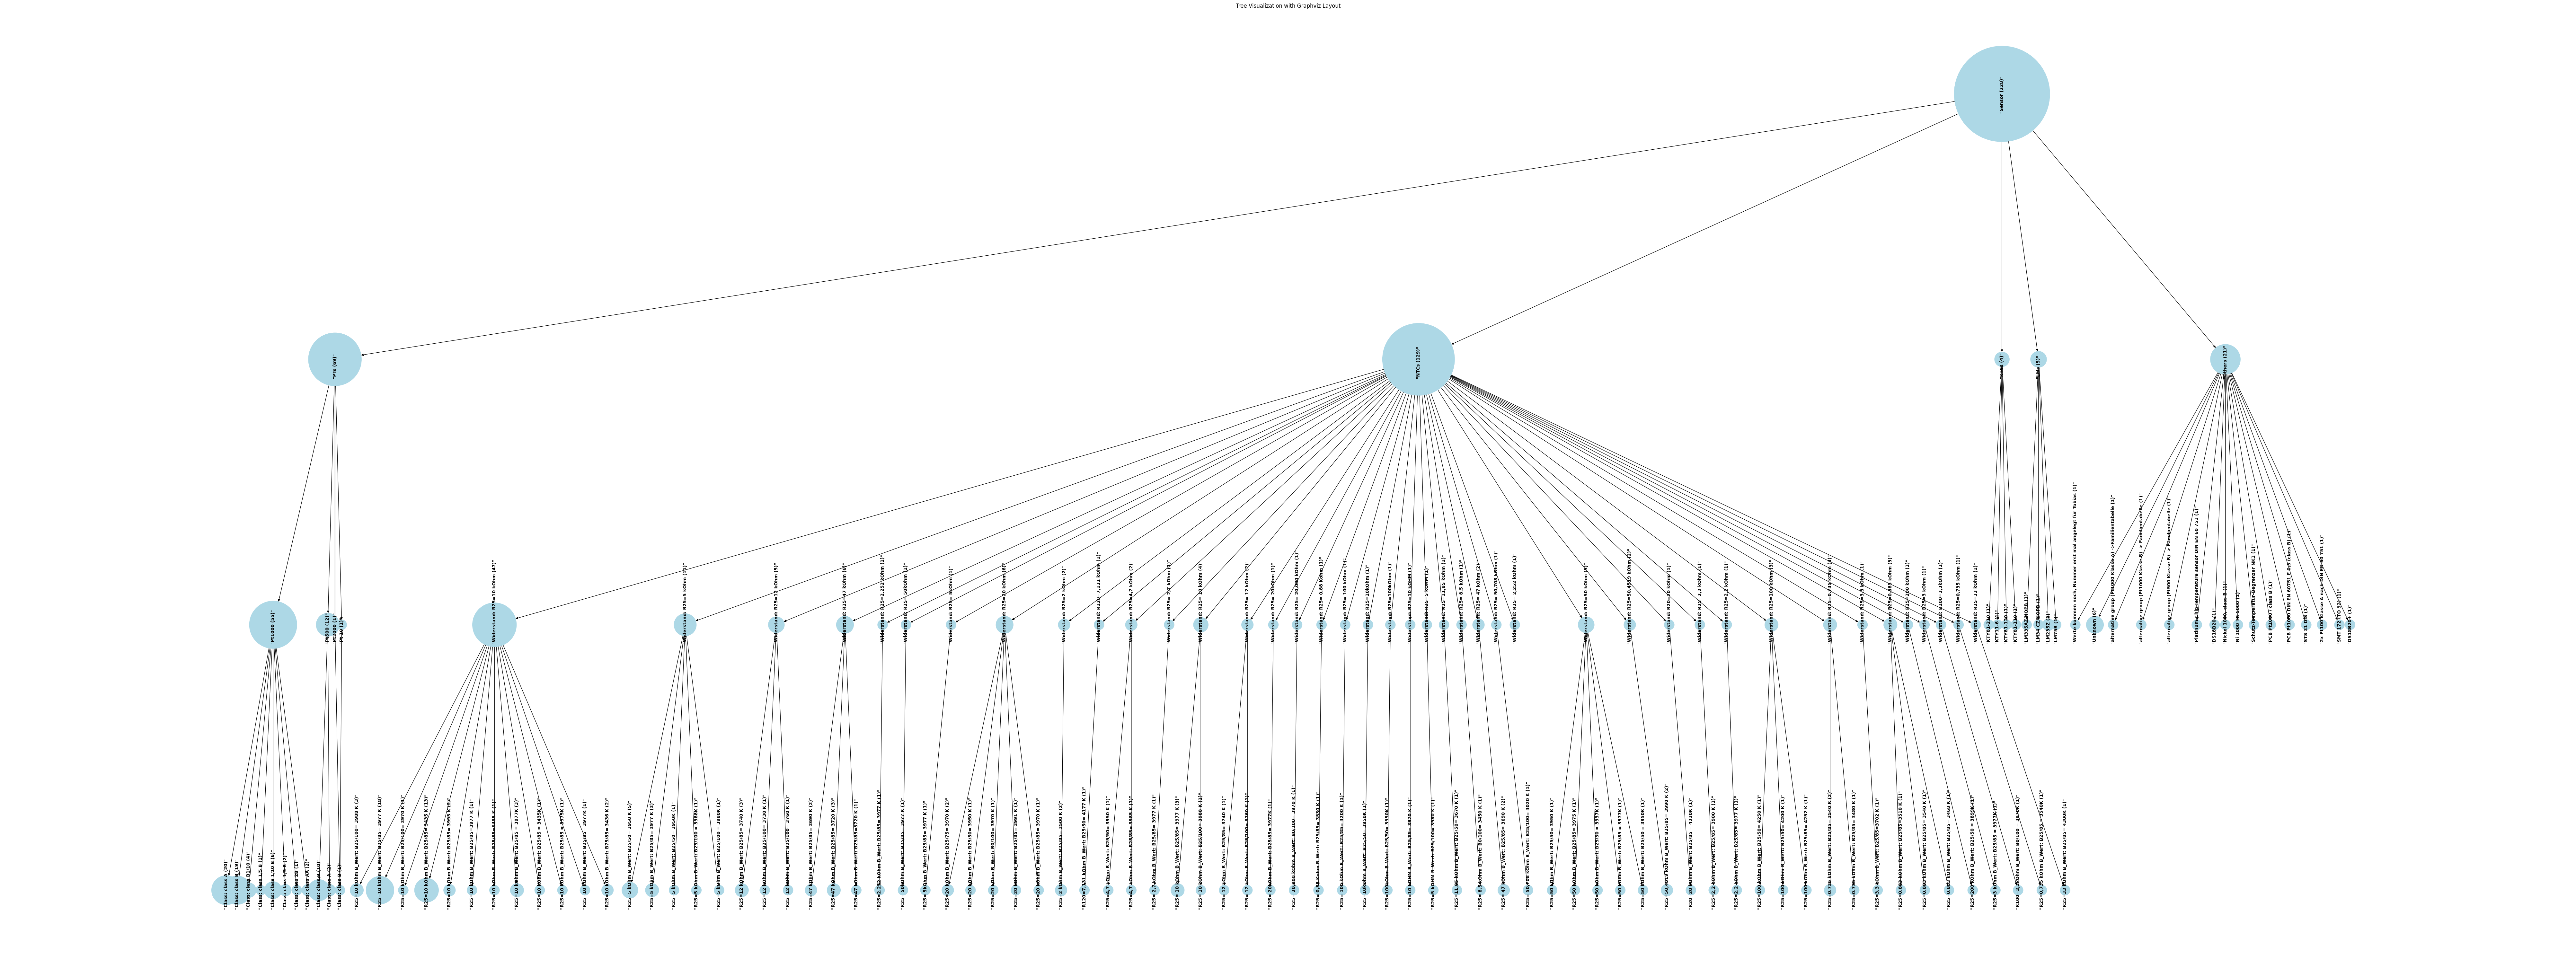

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

G = nx.DiGraph()

# A helper function to ensure node names are properly quoted if necessary
def format_node_name(name):
    # Check if the name contains special characters and quote it if it does
    if ':' in name or any(c in name for c in ['-', ' ', '(', ')', '[', ']', '{', '}']):
        return f'"{name}"'
    return name

# Function to add nodes and edges with formatted node names
def add_nodes_edges(node):
    for child in node.children:
        parent_name = format_node_name(node.name)
        child_name = format_node_name(child.name)
        G.add_edge(parent_name, child_name)  # Add an edge to the graph with formatted names
        add_nodes_edges(child)  # Recursive call to add nodes/edges for children

# Initialize the process with the root node
add_nodes_edges(root)

# Calculate node sizes based on the number of descendants (or any other metric)
node_sizes = {node: int(node[node.rfind("(")+1:node.rfind(")")])*200 + 300 for node in G.nodes()}  # Example metric: out_degree * 200 + 300


# Use the graphviz layout to draw the tree
plt.figure(figsize=(80, 30))  # Adjust the size of the figure as needed
pos = graphviz_layout(G, prog='dot')  # This uses the 'dot' layout
nx.draw(G, pos, with_labels=False, arrows=True, node_size=[node_sizes[node] for node in G.nodes()], node_color="lightblue", font_size=12, font_weight="bold")

# Custom labels drawing
label_pos = {key: (value[0], value[1] - 5) for key, value in pos.items()}  # Adjust label positions below nodes
for node, (x, y) in label_pos.items():
    plt.text(x, y, node, fontsize=10, fontweight="bold", ha='center', rotation=90)  # ha='center' centers the text horizontally at the position

plt.title('Tree Visualization with Graphviz Layout')
plt.show()

In [25]:
mat_hülsen_X, mat_hülsen_Y = php.split_X_Y(mat_hülsen_cp,"Unnamed: 1")

<h2>Compare the usage of the sensors</h2>

In [26]:
specs_cable_sensors = pd.read_csv("../../res/results/Specs_kabelfuehler.csv")
specs_cable_sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             665 non-null    int64  
 1   SAP_MATNR              665 non-null    object 
 2   sensor                 664 non-null    object 
 3   material_housing       662 non-null    object 
 4   cable                  658 non-null    object 
 5   connector_type         658 non-null    object 
 6   electrical_connection  658 non-null    object 
 7   original Temp          602 non-null    object 
 8   min. Temp              602 non-null    object 
 9   max. Temp              595 non-null    float64
dtypes: float64(1), int64(1), object(8)
memory usage: 52.1+ KB


In [27]:
len(specs_cable_sensors["SAP_MATNR"].unique())

665

I want to merge products with the different sensors to look how the usage is distributed.

In [28]:
merged_df = pd.merge(specs_cable_sensors,mat_hülsen_cp,on="sensor",how="left")
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1101 non-null   int64  
 1   SAP_MATNR                1101 non-null   object 
 2   sensor                   1095 non-null   object 
 3   material_housing         1098 non-null   object 
 4   cable                    1090 non-null   object 
 5   connector_type           1090 non-null   object 
 6   electrical_connection    1093 non-null   object 
 7   original Temp            1030 non-null   object 
 8   min. Temp                1030 non-null   object 
 9   max. Temp                1015 non-null   float64
 10  Unnamed: 1               755 non-null    object 
 11  28 Widerstand 
bei 25°C  760 non-null    float64
 12  Unnamed: 9               0 non-null      float64
 13  29 Widerstand 
bei 60°C  752 non-null    object 
 14  Hinweise Widerstand     

In [29]:
len(merged_df["SAP_MATNR"].unique())

665

<b>Conclusion:</b> It is not possible to compare this two table with the here used key "sensoren", because it is not unique. To look for the usage I have to use the Windchill API and the SAP_MATNR as key.

In [30]:
mat_hülsen_cp.loc[mat_hülsen_cp["Sensorart"] =="NTC"]

,Unnamed: 1,sensor,28 Widerstand \nbei 25°C,Unnamed: 9,29 Widerstand \nbei 60°C,Hinweise Widerstand,Sensorart,PT_Class,Widerstand,B_Wert
0,0360 0001,"NTC, R25=10 kOhm +/-1%\nB25/100= 3988 K +/-1%",94,NaN,Rmin = 2470 Ohm\nRnom = 2488 Ohm\nRmax = 2506 Ohm,NaN,NTC,NaN,R25=10 kOhm,B25/100= 3988 K
1,0360 0003,"NTC, R25=10 kOhm +/-0,2%\nB25/85= 3977 K +/-1%",107,NaN,Rmin= 2478 Ohm\nRnom= 2529 Ohm\nRmax= 2580 Ohm,NaN,NTC,NaN,R25=10 kOhm,B25/85= 3977 K
2,0360 0014,"NTC, R25=5 kOhm +/-1%\nB25/50= 3950 K +/-1%",103,NaN,Rmin= 1205 Ohm\nRnom= 1234 Ohm\nRmax= 1264 Ohm,NaN,NTC,NaN,R25=5 kOhm,B25/50= 3950 K
3,0360 0016,"NTC, R25=12 kOhm +/-1%\nB25/85= 3740 K +/-1%",96,NaN,Rmin= 3185 Ohm\nRnom= 3260 Ohm\nRmax= 3335 Ohm,NaN,NTC,NaN,R25=12 kOhm,B25/85= 3740 K
4,0360 0017\nGESPERRT,"NTC, R25=47 kOhm +/-1%\nB25/85= 3690 K +/-0,75%",102,NaN,Rmin= 12889 Ohm\nRnom= 12976 Ohm\nRmax= 13062 Ohm,NaN,NTC,NaN,R25=47 kOhm,B25/85= 3690 K
...,...,...,...,...,...,...,...,...,...,...
209,8034 1101,"NTC, R25=10 kOhm +/-1%\nB75/85= 3436 K +/-1%",68,NaN,Rmin = 2943 Ohm\nRnom = 3009 Ohm\nRmax = 3076 Ohm,NaN,NTC,NaN,R25=10 kOhm,B75/85= 3436 K
218,8070 1106,"NTC, R25=4,7 kOhm +/-1\nB25/85= 3985 K +/-1",84,NaN,Rmin = 1136 Ohm\nRnom = 1164 Ohm\nRmax = 1192...,NaN,NTC,NaN,"R25=4,7 kOhm",B25/85= 3985 K
219,8034 1101,"NTC, R25=10 kOhm +/-1\nB75/85= 3436 K +/-1",4,NaN,Rmin = 2943 Ohm\nRnom = 3009 Ohm\nRmax = ...,NaN,NTC,NaN,R25=10 kOhm,B75/85= 3436 K
221,8101 1201,"NTC, R25=12 kOhm +/-2%, B25/100= 3760 K +/-1,5...",80,NaN,Rmin = 3220 Ohm\nRnom = 3290 Ohm\nRmax = 3360...,NaN,NTC,NaN,R25=12 kOhm,B25/100= 3760 K
